# Preamble

+ After opening this notebook, tun these cells before anything else, to import libraries and define functions.

+ This notebook requires the following packages, which are pre-installed on Google Colab.

    + Python 3
    + NumPy
    + SciPy
    + Matplotlib

In [1]:
## Preamble / required packages
import numpy as np
import scipy
np.random.seed(0)

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline
## default first plot color is black
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['k'])  # Set default plot color to black
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)  # Reset to default colors


## Disable warnings
import warnings
warnings.filterwarnings('ignore')

# !apt-get install nvidia-cuda-toolkit
# !pip3 install numba
## These lines allow Google Colab to import and work with external files.
# %rm -rf illotka
# !git clone https://github.com/williamgilpin/illotka.git
# %cd illotka
# import importlib.util, sys
# module_path = "/content/illotka/base.py"
# spec = importlib.util.spec_from_file_location("base", module_path)
# base = importlib.util.module_from_spec(spec)
# sys.modules["base"] = base
# spec.loader.exec_module(base)


from base import *
from utils import *



## The generalized Lotka-Volterra model

We consider random ecosystems given by the generalized Lotka-Volterra equation,

$$
    \frac{dN_i}{dt} = N_i \left( r_i + \sum_{j=1}^N A_{ij} N_j \right)
$$

where $N_i$ is the population of species $i$, $r_i$ is the intrinsic growth rate of species $i$, and $A_{ij}$ is the interaction coefficient between species $i$ and $j$.

To study the behavior of this model, we consider the case where $r_i \sim \mathcal{N}(0,1)$, and the matrix $A$ has the form 

$$
    A = Q - d\, I
$$
where $I \in \mathbb{R}^{N \times N}$ is the identity matrix, $Q_{ij} \sim \mathcal{N}(0,1)$ and $d$ is a constant density-limitation.




(0.0, 1.0451813025310988)

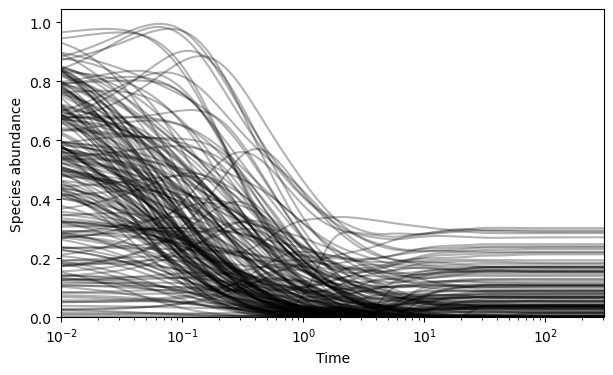

In [3]:
# Set the simulation parameters
tmax = 20000 # Maximum integration duration
n = 200 # Number of species
d = 12.5 # Density-limitation

## Initialize the model
eq = GaussianLotkaVolterra(n)
eq.A = np.random.normal(size=(n, n)) - d * np.identity(n)
eq.r = np.random.normal(size=n)

## Initial conditions
ic = np.random.uniform(size=n)

## Numerically integrate the model
t, y = eq.integrate(tmax, ic)

plt.figure(figsize=(7, 4))
plt.semilogx(t, y, color="k", lw=1.5, alpha=0.3);
plt.xlabel("Time")
plt.ylabel("Species abundance")
plt.xlim(1e-2, np.max(t))
plt.ylim(0, None)



### How many species survive?

In [4]:
nonzero_remaining = np.sum(y[-1] > 1e-12) # Precision floor
print(f"{nonzero_remaining} species out of {n} remain")

102 species out of 200 remain


[################### ] 



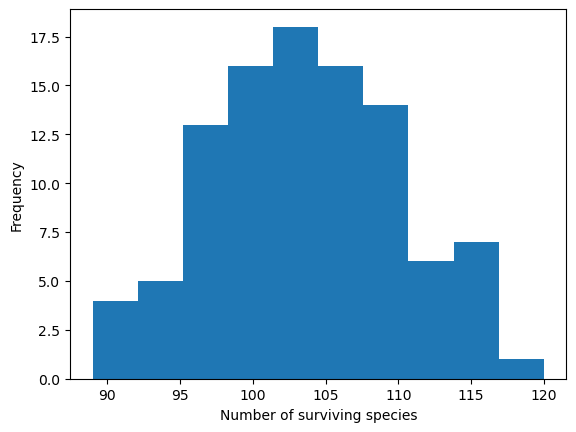

In [5]:
n_replicates = 100
tmax = 1000
number_survive = []
for i in range(100):
    progress_bar(i, n_replicates) # Print progress bar for loop

    eq = GaussianLotkaVolterra(n)
    eq.A = np.random.normal(size=(n, n)) - d * np.identity(n)
    # eq.A = eq.A * np.identity(n) # Wipe out all off-diagonal elements
    eq.r = np.random.normal(size=n)
    t, y = eq.integrate(tmax, ic)

    n_survive = np.sum(y[-1] > 1e-12)
    number_survive.append(n_survive)

plt.hist(number_survive)
plt.xlabel("Number of surviving species");
plt.ylabel("Frequency");


In [6]:
print(np.mean(number_survive))
print(np.std(number_survive))

103.5
6.323764701504951


In [7]:
print(0.5 * n)
print(np.sqrt(n * 0.5 * (1 - 0.5)))

100.0
7.0710678118654755


In [8]:
print(np.mean(number_survive))
print(np.std(number_survive))

103.5
6.323764701504951


### Properties of the Random Lotka-Volterra model

Proven in [Serván et al. 2018](https://www.nature.com/articles/s41559-018-0603-6).

1. On average, half of all species survive at steady-state. Across replicates, the number of surviving species follows a binomial distribution with mean $n/2$.
2. For a given matrix $A$, the steady-state solution is unique (global attractor).
3. For a given matrix $A$, there always exists a density-limitation $d$ that that leads to a single stable steady-state.

Main assumption: Interactions and growth rates are drawn from a symmetric distribution with finite variance.


(0.0, 1.109832473763459)

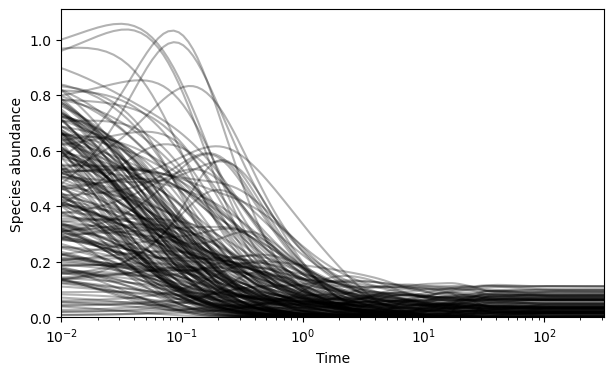

In [14]:
# Set the simulation parameters
tmax = 20000 # Maximum integration duration
n = 200 # Number of species
d = 19.5 # Density-limitation
np.random.seed(0)

## Initialize the model
eq = GaussianLotkaVolterra(n)
eq.A = np.random.standard_t(df=3, size=(n, n)) - d * np.identity(n)
eq.r = np.random.normal(size=n)

## Initial conditions
ic = np.random.uniform(size=n)

## Numerically integrate the model
t, y = eq.integrate(tmax, ic)

plt.figure(figsize=(7, 4))
plt.semilogx(t, y, color="k", lw=1.5, alpha=0.3);
plt.xlabel("Time")
plt.ylabel("Species abundance")
plt.xlim(1e-2, np.max(t))
plt.ylim(0, None)



## How long does it take to reach the steady-state?

We define the settling time. Given a steady-state solution $\mathbf{N}^*$, the settling time is the time it takes for the solution to reach a given tolerance $\epsilon$ of the steady-state.

$$
    \min_{t} \bigg( \| \mathbf{N}(t) - \mathbf{N}^* \| < \epsilon \bigg)
$$




In [62]:
def compute_settling_time(traj, eps=1e-6):
    """
    Compute the settling time from a multivariate time series. 
    If the trajectory does not reach the steady-state within the integration time, 
    return a NaN.
    """
    final_value = traj[-1]
    final_index = np.where(np.linalg.norm((traj - final_value) / final_value, axis=1) < eps)[0]
    if len(final_index) == 0:
        return np.nan
    else:
        return final_index[0]




# How does the settling time depend on the number of species?







In [ ]:

n_vals = np.unique(np.logspace(1, 4, 200).astype(int)) # Range of species numbers to consider
tmax = 20000 # Maximum integration time
d = 21.5 # Density-limitation


## Loop over species numbers and compute the settling time for each
all_t = []
all_y = []
settling_times = []
for i,n in enumerate(n_vals):
    progress_bar(i, len(n_vals))

    eq = GaussianLotkaVolterra(n)
    eq.A = np.random.normal(size=(n, n)) - d * np.identity(n)
    eq.r = np.random.normal(size=n)
    ic = np.random.uniform(size=n)
    t, y = eq.integrate(tmax, ic)
    all_t.append(t.copy())
    all_y.append(y.copy())
    
    tind = compute_settling_time(y)
    if not np.isnan(tind):
        settling_times.append(t[tind])
    else:
        settling_times.append(np.nan)


Text(0, 0.5, 'Settling time')

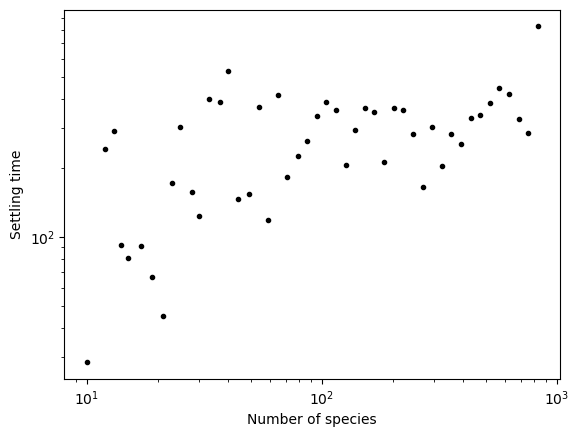

In [75]:
plt.loglog(n_vals, settling_times, '.k')
plt.xlabel("Number of species")
plt.ylabel("Settling time")

# Supertransients

+ Chimeras in the Kuramoto model
+ Pipe turbulence
+ Couple map lattices

# When would supertransients appear in the Lotka-Volterra model?



$$
    A = P^\top (Q - d\, I) P + \epsilon E
$$

where $Q_{ij} \sim \mathcal{N}(0,1)$, $E_{ij} \sim \mathcal{N}(0,1)$, $P$ is a low-rank assigment matrix imposing functional redundancy. $\epsilon \ll 1$ is a small constant that controls the degree to which two species matrix deviate from exact redundancy.

# Equilibrium solves an optimization problem




In [ ]:
## Use a built-in nonnegative least squares solver

# A, r = eq.A, eq.r

# from scipy.optimize import nnls
# sol_exact = nnls(A, r)







# How sensitive is the approach to equilibrium?

# Low-dimensional projections of the dynamics




## The ill-conditioned Lotka-Volterra model

We consider random ecosystems given by the generalized Lotka-Volterra equation,

$$
    \frac{dN_i}{dt} = N_i \left( r_i + \sum_{j=1}^N A_{ij} N_j \right)
$$

where $N_i$ is the population of species $i$, $r_i$ is the intrinsic growth rate of species $i$, and $A_{ij}$ is the interaction coefficient between species $i$ and $j$. The steady-state solutions of this equation has the form

$$
    -A \mathbf{N}^* = \mathbf{r}
$$

where $N_i \geq 0$ for all $i$.

In this notebook, we explore the behavior of this model when the interaction matrix $A_{ij}$, and the growth rates $r_i$ are drawn from random distributions. Specifically, we consider the case where $r_i \sim \mathcal{N}(0,1)$, and the matrix $A$ has the form

$$
    A = P^\top (Q - d\, I) P + \epsilon E
$$

where $Q_{ij} \sim \mathcal{N}(0,1)$, $E_{ij} \sim \mathcal{N}(0,1)$, $P$ is a low-rank matrix imposing functional redundancy, $d$ is a constant density-limitation, and $\epsilon \ll 1$ is a small constant.


Numerical stability observed: True


Text(0.5, 1.0, 'Eigenvalues of Jacobian')

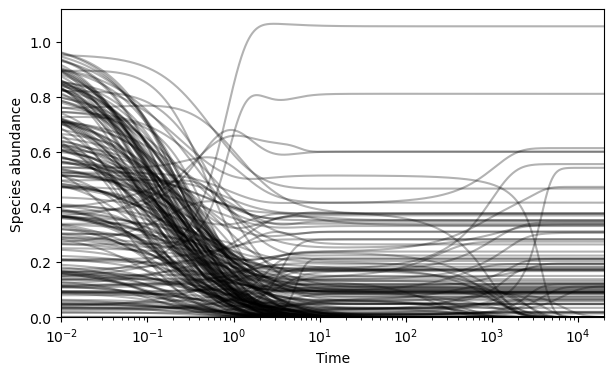

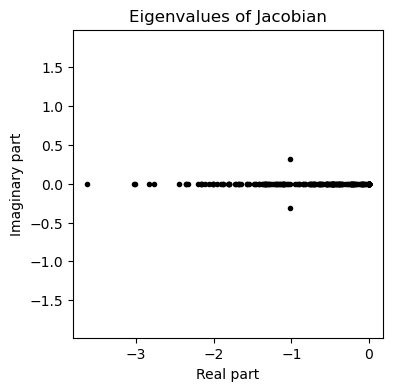

In [8]:
from scipy.integrate import solve_ivp

## Load local functions
import sys
import base
import utils
from base import RandomLotkaVolterra
from utils import levenshtein


tlim = (0, 20000) # Integration interval
n_val = 200 # Number of species

## Initialize the model
eq = RandomLotkaVolterra(n_val, sigma=2.0, d=4.5, kfrac=0.2, eps=0.001, random_state=0, connectivity=0.01)

## Initial conditions
ic = np.random.uniform(size=eq.n)

## Numerical integration
fsol = solve_ivp(eq, tlim, ic[:n_val], jac=eq.jac, **eq.integrator_args)


## Check that the found solution is stable
sol_final = fsol.y[:, -1]
jac_final = eq.jac(0, sol_final)
eigs = np.linalg.eigvals(jac_final)
print(f"Numerical stability observed: {np.all(np.real(eigs) < 0)}")

## Plot the solution
plt.figure(figsize=(7, 4))
plt.semilogx(fsol.t, fsol.y.T, color="k", lw=1.5, alpha=0.3);
plt.xlabel("Time")
plt.ylabel("Species abundance")
plt.xlim(1e-2, np.max(fsol.t))
plt.ylim(0, None)

eigvals = np.linalg.eigvals(jac_final)
plt.figure(figsize=(4, 4))
plt.plot(np.real(eigvals), np.imag(eigvals), '.k')
plt.xlabel("Real part")
plt.ylabel("Imaginary part")
plt.axis("equal")
plt.title("Eigenvalues of Jacobian")

## Dimensionality reduction as preconditioning

Original condition number:  723977.2579774971
Fast condition number:  1.8180378841429419
Slow condition number:  3.1628804216115274


(0.01, 20000.0)

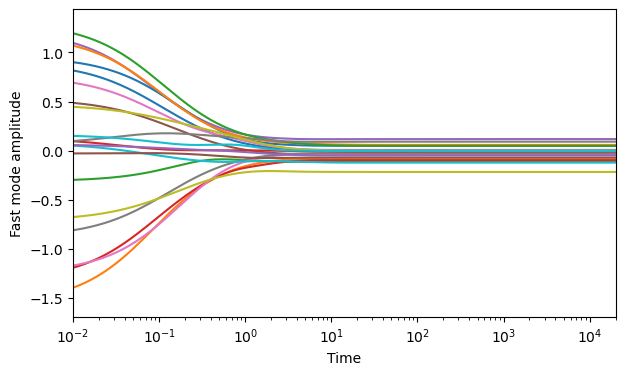

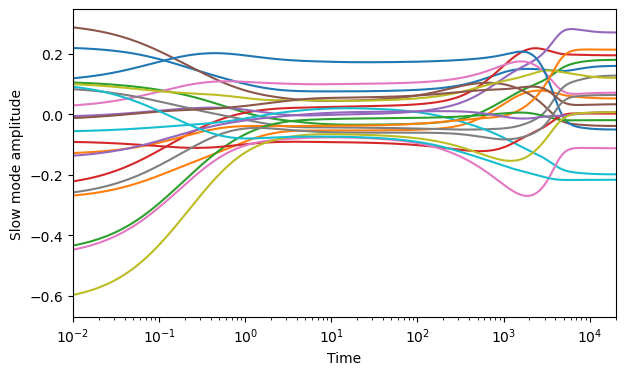

In [21]:
## Separate timescales

print("Original condition number: ", np.linalg.cond(eq.A))




U, S, V = np.linalg.svd(eq.A)
P_fast, P_slow = V[:20, :], V[-20:, :]
yp_fast = P_fast @ fsol.y # First k modes
yp_slow = P_slow @ fsol.y # Last k modes

print("Fast condition number: ", np.linalg.cond(P_fast @ eq.A))
print("Slow condition number: ", np.linalg.cond(P_slow @ eq.A))


plt.figure(figsize=(7, 4))
plt.semilogx(fsol.t, yp_fast.T);
plt.xlabel("Time")
plt.ylabel("Fast mode amplitude")
plt.xlim(1e-2, np.max(fsol.t))
# dg.better_savefig("lv_traj_fast_dark.png", dpi=600)

plt.figure(figsize=(7, 4))
plt.semilogx(fsol.t, yp_slow.T);
plt.xlabel("Time")
plt.ylabel("Slow mode amplitude")
plt.xlim(1e-2, np.max(fsol.t))
# dg.better_savefig("lv_traj_slow_dark.png", dpi=600)

